In [ ]:
from google.colab import files

print("Lütfen indirdiğiniz kaggle.json dosyasını seçin:")
files.upload()

Lütfen indirdiğiniz kaggle.json dosyasını seçin:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beyzaydn","key":"de9644b221ddfa4a50a1c237ce6320b2"}'}

In [ ]:
# Kaggle klasörünü oluştur
!mkdir -p ~/.kaggle

# kaggle.json dosyasını bu klasöre kopyala
!cp kaggle.json ~/.kaggle/

# Dosya izinlerini ayarla
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Intel Image Classification veri setini indir
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 86% 298M/346M [00:03<00:00, 82.6MB/s]
100% 346M/346M [00:03<00:00, 111MB/s] 


In [ ]:
# İndirilen zip dosyasını dışarı aktar
!unzip -q intel-image-classification.zip

**Kütüphanelerin Yüklenmesi ve Ortam Hazırlığı**

In [ ]:
# Gerekli kütüphaneleri içe aktarıyoruz
import numpy as np # Sayısal işlemler ve matematiksel diziler için
import pandas as pd # Veri analizi ve manipülasyonu için
import matplotlib.pyplot as plt # Grafikler ve görseller oluşturmak için
import seaborn as sns # Daha estetik grafikler için
import os # İşletim sistemiyle ilgili işlemler (dosya/klasör yönetimi) için
import random # Rastgele seçimler yapmak için
import matplotlib.image as mpimg # Resimleri okumak için
import tensorflow as tf # Derin öğrenme ana kütüphanesi

import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


**Veri Setini Keşfetme ve Görselleştirme**

In [ ]:
# Veri setimizin ana klasör yollarını tanımlıyoruz
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test'

# Sınıf isimlerini alıyoruz
import os
class_names = sorted(os.listdir(train_dir))

print("Eğitim Seti Yolu:", train_dir)
print("Test Seti Yolu:", test_dir)
print("Sınıflar:", class_names)

Eğitim Seti Yolu: seg_train/seg_train
Test Seti Yolu: seg_test/seg_test
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Sınıflar (Kategoriler): ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Toplam Sınıf Sayısı: 6

Eğitim setindeki her sınıfa ait görsel sayıları:
- buildings: 2191 görsel
- forest: 2271 görsel
- glacier: 2404 görsel
- mountain: 2512 görsel
- sea: 2274 görsel
- street: 2382 görsel


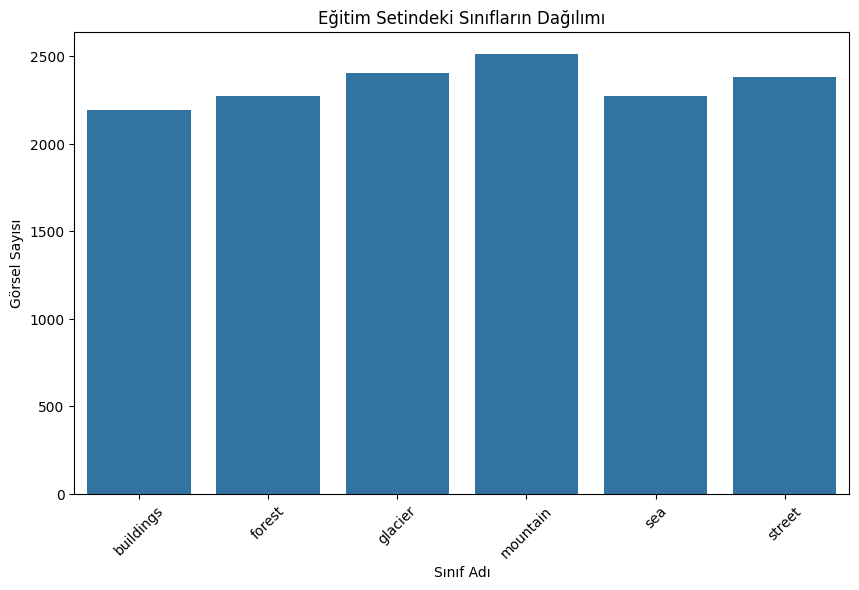

In [ ]:
# Eğitim klasöründeki sınıfları listeliyoruz
class_names = sorted(os.listdir(train_dir))
print("Sınıflar (Kategoriler):", class_names)
print("Toplam Sınıf Sayısı:", len(class_names))

print("\nEğitim setindeki her sınıfa ait görsel sayıları:")
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    # os.listdir() o klasördeki tüm dosyaları bir liste olarak verir, len() ile sayısını alırız.
    num_images = len(os.listdir(class_path))
    image_counts[class_name] = num_images
    print(f"- {class_name}: {num_images} görsel")

# Görsel sayılarını bir bar grafiği ile gösterelim
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Eğitim Setindeki Sınıfların Dağılımı')
plt.xlabel('Sınıf Adı')
plt.ylabel('Görsel Sayısı')
plt.xticks(rotation=45)
plt.show()

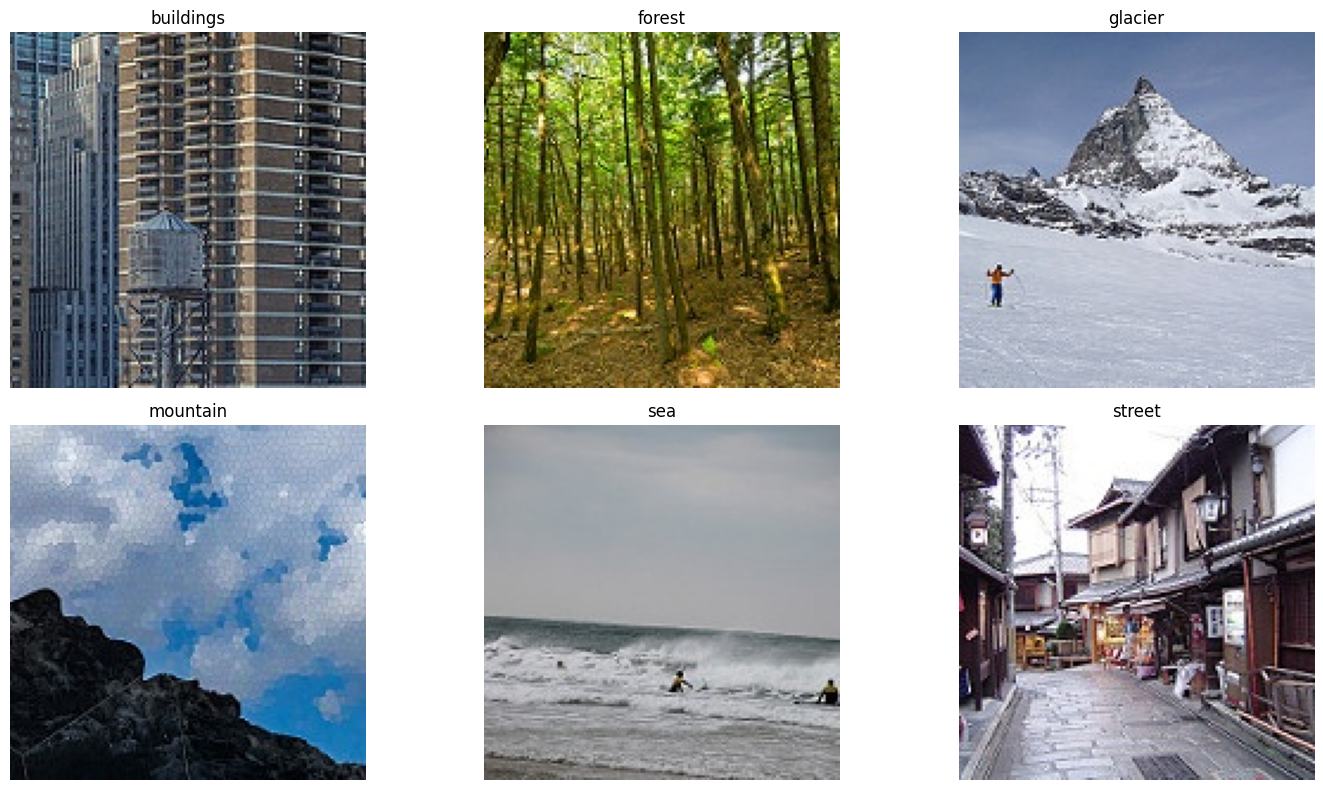

In [ ]:
# Her sınıftan rastgele bir görseli göstermek için fonksiyon
def show_random_images(class_names, directory):
    fig = plt.figure(figsize=(15, 8))

    # 2 satır ve 3 sütunluk bir görsel alanı oluşturuyoruz (toplam 6 sınıf için)
    rows, cols = 2, 3

    for i, class_name in enumerate(class_names):
        ax = fig.add_subplot(rows, cols, i + 1)

        # O sınıfa ait görsellerin listesini alıyoruz
        image_files = os.listdir(os.path.join(directory, class_name))

        # Listeden rastgele bir görsel seçiyoruz
        random_image_file = random.choice(image_files)

        # Görselin tam yolunu oluşturuyoruz
        image_path = os.path.join(directory, class_name, random_image_file)

        # Görseli okuyoruz
        image = mpimg.imread(image_path)

        # Görseli ekrana çizdiriyoruz
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off') # Eksenleri (sayıları) gizliyoruz

    plt.tight_layout() # Görsellerin birbirine girmesini engeller
    plt.show()

# Fonksiyonu çağırarak görselleri gösterelim
show_random_images(class_names, train_dir)

In [ ]:
# Tüm görselleri yeniden boyutlandıracağımız hedef boyutu belirliyoruz.
# CNN'ler sabit boyutlu girdilerle çalışır.
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Modelin her iterasyonda kaç görsel işleyeceğini belirliyoruz (batch size).
BATCH_SIZE = 32

**Veri Ön İşleme ve Veri Çoğaltma (Data Augmentation)**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Eğitim verisi için veri çoğaltma (augmentation) ayarları ile bir jeneratör oluşturuyoruz.
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Piksel değerlerini 0-1 arasına ölçeklendir.
    rotation_range=20,       # Görüntüyü rastgele 20 dereceye kadar döndür.
    width_shift_range=0.2,   # Görüntüyü yatayda %20'ye kadar rastgele kaydır.
    height_shift_range=0.2,  # Görüntüyü dikeyde %20'ye kadar rastgele kaydır.
    shear_range=0.2,         # Görüntüye kesme/eğme dönüşümü uygula.
    zoom_range=0.2,          # Görüntüyü %20'ye kadar rastgele yakınlaştır.
    horizontal_flip=True,    # Görüntüyü rastgele yatay olarak çevir.
    fill_mode='nearest'      # Dönüşümler sırasında oluşabilecek boş pikselleri en yakın pikselle doldur.
)

# Test/Doğrulama verisi için SADECE ölçeklendirme işlemi yapıyoruz.
# Bu veriyi çoğaltmıyoruz!
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Eğitim jeneratörünü oluşturuyoruz.
# train_dir içindeki klasörlerden verileri okuyacak.
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Tüm görselleri 150x150'ye yeniden boyutlandır.
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Sınıflandırma türü. Çok sınıflı olduğu için 'categorical'.
    shuffle=True # Verileri her epoch başında karıştır.
)

# Test jeneratörünü oluşturuyoruz.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Test verisini karıştırmıyoruz ki sonuçları tutarlı bir şekilde değerlendirebilelim.
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Modelin Oluşturulması ve Eğitimi**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Modelimizi Sequential (sıralı) olarak başlatıyoruz.
model = Sequential()

# ---- 1. Conv Bloğu ----
# 32 filtreli, 3x3 boyutunda bir CNN katmanı.
# input_shape: Modele girecek ilk verinin boyutu. (150x150 piksel, 3 renk kanalı (RGB))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# 2x2'lik bir pencere ile özellik haritasının boyutunu küçültüyoruz.
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- 2. Conv Bloğu ----
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- 3. Conv Bloğu ----
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Sınıflandırma Katmanları ----
# 2D veriyi (matrisi) 1D vektöre düzleştiriyoruz.
model.add(Flatten())

# 512 nörondan oluşan tam bağlantılı (Dense) katman.
model.add(Dense(512, activation='relu'))

# Overfitting'i önlemek için nöronların %50'sini rastgele kapatıyoruz.
model.add(Dropout(0.5))

# Çıkış katmanı. 6 sınıfımız olduğu için 6 nöron var.
# 'softmax' aktivasyonu, her sınıf için bir olasılık değeri üretir ve bu olasılıkların toplamı 1 olur.
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Eğitim sürecindeki tüm logları (accuracy, loss vb.) 'history' adlı bir değişkene kaydediyoruz.

EPOCHS = 20 # Modelin veri setini baştan sona kaç kez göreceği.

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), # Her epoch'ta kaç adım atılacağı (toplam_eğitim_verisi / batch_size)
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(test_generator) # Her epoch sonunda doğrulama için kaç adım atılacağı (toplam_test_verisi / batch_size)
)

print("\nEğitim tamamlandı!")

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 221ms/step - accuracy: 0.4859 - loss: 1.3040 - val_accuracy: 0.6707 - val_loss: 0.8679
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 206ms/step - accuracy: 0.6549 - loss: 0.9034 - val_accuracy: 0.7427 - val_loss: 0.7184
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 92s 209ms/step - accuracy: 0.7084 - loss: 0.7925 - val_accuracy: 0.7867 - val_loss: 0.5872
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 208ms/step - accuracy: 0.7427 - loss: 0.7091 - val_accuracy: 0.8280 - val_loss: 0.5090
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 207ms/step - accuracy: 0.7681 - loss: 0.6500 - val_accuracy: 0.7827 - val_loss: 0.6505
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 208ms/step - accuracy: 0.7739 - loss: 0.6267 - val_accuracy: 0.7970 - val_loss: 0.5534
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 208ms/step - accuracy: 0.7764 - loss: 0.6060 - val_accuracy: 0.8330 - val_loss: 0.4787
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 207ms/step - accuracy: 0.8049 - loss: 

**Model Performansının Değerlendirilmesi**

Eğitim sırasında kaydedilen doğruluk (accuracy) ve kayıp (loss) metrikleri, hem eğitim hem de doğrulama (validation) setleri için çizdirilir. Bu grafikler, modelin öğrenme sürecinin sağlığını kontrol etmek ve en önemlisi overfitting (ezberleme) veya underfitting (yetersiz öğrenme) olup olmadığını tespit etmek için önemlidir. Eğitim ve doğrulama eğrilerinin birbirine yakın ve paralel hareket etmesi, modelin başarılı bir şekilde genelleme yaptığını gösterir.

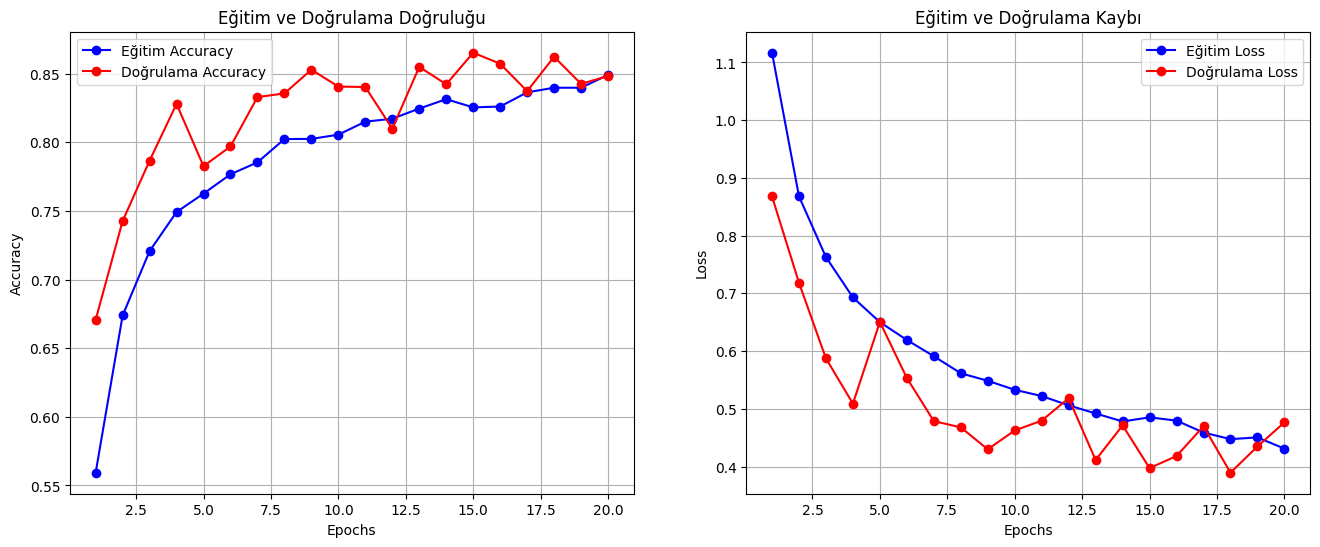

In [ ]:
import matplotlib.pyplot as plt

# Eğitim sonuçlarını history objesinden alıyoruz
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# İki grafik için bir figure ve axes oluşturuyoruz
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Doğruluk (Accuracy) Grafiği
ax[0].plot(epochs, acc, 'bo-', label='Eğitim Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Doğrulama Accuracy')
ax[0].set_title('Eğitim ve Doğrulama Doğruluğu')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Kayıp (Loss) Grafiği
ax[1].plot(epochs, loss, 'bo-', label='Eğitim Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Doğrulama Loss')
ax[1].set_title('Eğitim ve Doğrulama Kaybı')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Sınıflandırma Raporu
              precision    recall  f1-score   support

   buildings       0.74      0.89      0.81       437
      forest       0.98      0.95      0.96       474
     glacier       0.87      0.78      0.82       553
    mountain       0.86      0.73      0.79       525
         sea       0.88      0.85      0.87       510
      street       0.80      0.90      0.85       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



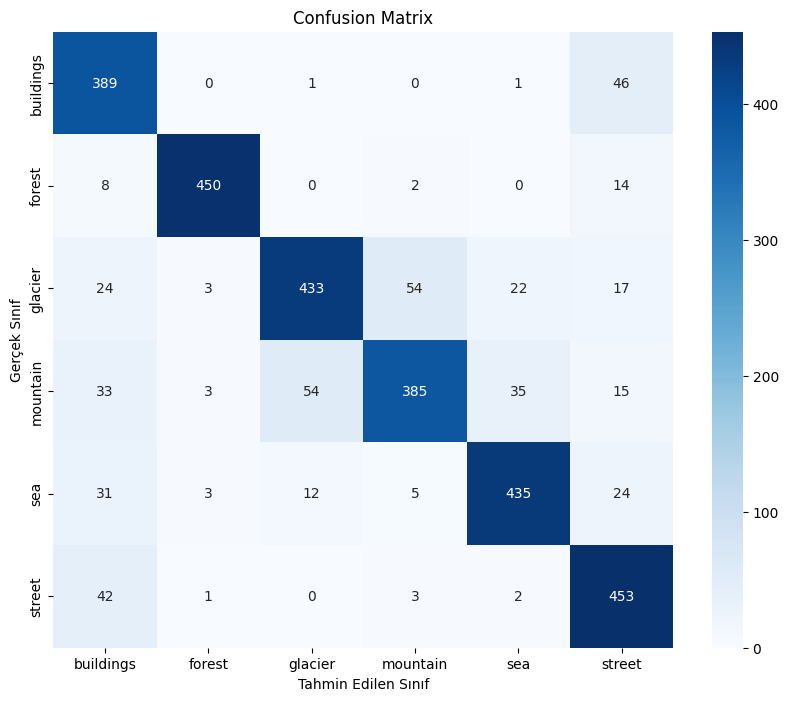

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Modelin test jeneratörü üzerindeki tahminlerini alıyoruz
predictions = model.predict(test_generator, steps=len(test_generator))
# Tahminler olasılık şeklinde gelir, en yüksek olasılığa sahip sınıfın indeksini alıyoruz
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek etiketleri test jeneratöründen alıyoruz
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Sınıflandırma Raporu
print("Sınıflandırma Raporu")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(true_classes, predicted_classes)

# Matrisi heatmap ile görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.cm as cm

# Bu fonksiyon, resmi TensorFlow dökümantasyonundan alınmıştır.
# Bir önceki denememize göre daha temel seviyede çalışarak 'kayıp bağlantı' sorununu aşar.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Girdi ve çıktıları belirleyen bir model oluşturuyoruz
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output],
    )

    # 2. Gradyanları hesaplamak için GradientTape kullanıyoruz
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. İlgilendiğimiz sınıfın, çıktı özellik haritasına göre gradyanını alıyoruz
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 4. Her özellik haritasındaki ortalama gradyanı alıyoruz
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Özellik haritası kanallarını gradyanların önemiyle çarpıyoruz
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Isı haritasını 0-1 arasına normalize ediyoruz
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10) # 1e-10 sıfıra bölme hatasını engeller
    return heatmap.numpy()

print("Grad-CAM fonksiyonu başarıyla tanımlandı.")

Grad-CAM fonksiyonu başarıyla tanımlandı.


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_functional_model():
    # Modelin girdi katmanını tanımlıyoruz
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Katmanları birbirine bağlayarak mimariyi oluşturuyoruz
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Grad-CAM için bu katmanın adını saklayalım
    x = Conv2D(128, (3, 3), activation='relu', name="conv2d_2_functional")(x) # Katmana özel bir isim verdik
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Çıkış katmanı
    outputs = Dense(6, activation='softmax')(x)

    # Girdi ve çıktıları belirterek modeli oluşturuyoruz
    functional_model = Model(inputs=inputs, outputs=outputs)
    return functional_model

# Yeni fonksiyonel modeli oluştur
functional_model = create_functional_model()

# Eski Sequential modelimizdeki (adı 'model') eğitilmiş ağırlıkları yeni modele aktar
functional_model.set_weights(model.get_weights())

# Yeni modelin özetini kontrol edelim (eskisiyle aynı olmalı)
functional_model.summary()

print("\nModel başarıyla Fonksiyonel API modeline dönüştürüldü ve ağırlıklar aktarıldı.")

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_functional (Conv2D)    │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)


Model başarıyla Fonksiyonel API modeline dönüştürüldü ve ağırlıklar aktarıldı.


**Model Yorumlanabilirliği (Grad-CAM)**

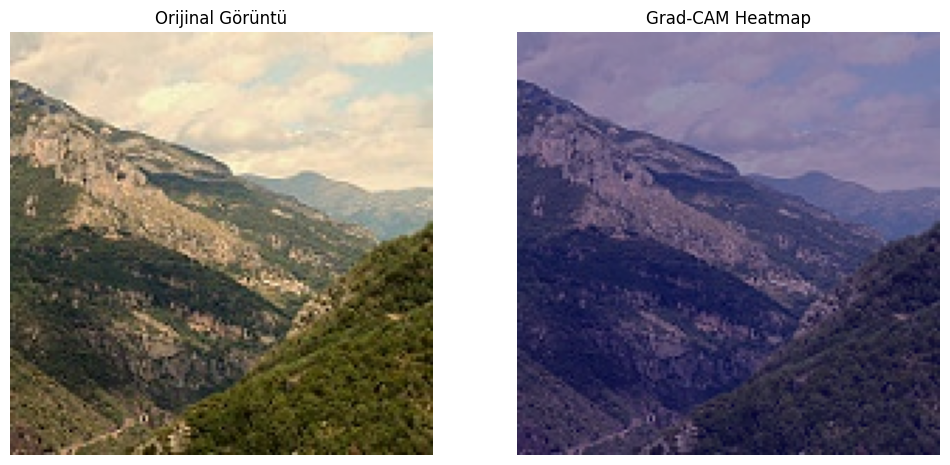

In [ ]:
from PIL import Image

# 1. Analiz edilecek görsel (aynı)
img_path = os.path.join(test_dir, 'mountain', os.listdir(os.path.join(test_dir, 'mountain'))[5])
img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)

# 2. Son evrişim katmanının adı
last_conv_layer_name = "conv2d_2_functional"

# 3. Isı haritasını üretiyoruz
heatmap = make_gradcam_heatmap(img_array_expanded, functional_model, last_conv_layer_name)

# 4. Orijinal görüntüyü ve ısı haritasını PIL Image formatına çeviriyoruz
original_pil = Image.open(img_path)
heatmap_resized = cv2.resize(heatmap, (original_pil.width, original_pil.height))
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = Image.fromarray(np.uint8(jet_colors[np.uint8(255 * heatmap_resized)] * 255))

# 5. İki görüntüyü yarı saydam olarak birleştiriyoruz
# alpha=0.4, ısı haritasının %40 görünür olmasını sağlar.
superimposed_img = Image.blend(original_pil, jet_heatmap, alpha=0.4)

# 6. Sonuçları gösteriyoruz
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(original_pil)
ax[0].set_title('Orijinal Görüntü')
ax[0].axis('off')

ax[1].imshow(superimposed_img)
ax[1].set_title('Grad-CAM Heatmap')
ax[1].axis('off')

plt.show()

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.2 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf

# Bu fonksiyon, Keras Tuner'ın her denemede çağıracağı model oluşturma planıdır.
def build_model(hp):
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 1. Ayarlanabilir Hiperparametre: Son Conv katmanındaki filtre sayısı
    hp_filters = hp.Choice('filters', values=[64, 128, 256])
    x = Conv2D(hp_filters, (3, 3), activation='relu')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # 2. Ayarlanabilir Hiperparametre: Dropout oranı
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(hp_dropout)(x)

    outputs = Dense(6, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # 3. Ayarlanabilir Hiperparametre: Öğrenme Oranı
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

print("Ayarlanabilir model oluşturma fonksiyonu 'build_model' tanımlandı.")

Ayarlanabilir model oluşturma fonksiyonu 'build_model' tanımlandı.


**Hiperparametre Optimizasyonu**

Bu adımda, en iyi hiperparametre kombinasyonunu bulmak için Keras Tuner kütüphanesini ve RandomSearch (Rastgele Arama) stratejisini kullanıyoruz. Keras Tuner, belirlediğimiz aralıklarda farklı hiperparametre değerleriyle otomatik olarak birden çok model eğitir ve en iyi performansı gösteren kombinasyonu bize raporlar. Bu süreç, manuel deneme-yanılmaya göre çok daha verimli bir yöntemdir.

In [ ]:
# RandomSearch tuner'ını oluşturuyoruz.
# Amacımız 'val_accuracy' metriğini en yükseğe çıkarmak.
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Toplamda 5 farklı hiperparametre kombinasyonu dene
    executions_per_trial=1, # Her kombinasyonu 1 kez eğit
    directory='my_dir', # Sonuçların kaydedileceği klasör
    project_name='intel_image_tuning'
)

# Aramayı başlatmadan önce arama alanının özetini görelim
tuner.search_space_summary()

print("\nHiperparametre arayışı başlıyor...")

# Aramayı başlat.
tuner.search(
    train_generator,
    epochs=5, # Her bir denemeyi 5 epoch için eğit
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

Trial 5 Complete [00h 08m 28s]
val_accuracy: 0.18433333933353424

Best val_accuracy So Far: 0.8183333277702332
Total elapsed time: 00h 42m 01s


**Genel Sonuç ve Proje Özeti**

Sıfırdan tasarlanan ve eğitilen CNN modeli, test verisi üzerinde %85 gibi başarılı bir doğruluk oranına ulaşmıştır. Eğitim ve doğrulama eğrilerinin analizi, veri çoğaltma ve dropout gibi teknikler sayesinde modelin overfitting (ezberleme) yapmadığını göstermiştir. Grad-CAM ile yapılan yorumlanabilirlik analizi, modelin anlamsal olarak doğru özellikleri öğrendiğini kanıtlamıştır. Son olarak yapılan hiperparametre optimizasyon süreci ise, başlangıçta manuel olarak tasarlanan modelin zaten başarılı hiperparametrelere sahip olduğunu doğrulamıştır.